In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sqlite3
import datetime as dt
from datetime import datetime

In [2]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance, LabelPowerset

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amars\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amars\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
start = datetime.now()
con = sqlite3.connect('train.db')
chunk_size = 180000
j = 0
index_start = 1
for df in pd.read_csv('../../StackOverFlow/Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunk_size, iterator=True, encoding='utf-8'):
    df.index += index_start
    j += 1
    print(f'{j*chunk_size} rows')
    df.to_sql('data', con, if_exists = 'append')
    index_start = df.index[-1] + 1
print("Time taken to run this cell :", datetime.now() - start)

C:\Users\Amars\Anaconda3\envs\Stackoverflow\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
1260000 rows
1440000 rows
1620000 rows
1800000 rows
1980000 rows
2160000 rows
2340000 rows
2520000 rows
2700000 rows
2880000 rows
3060000 rows
3240000 rows
3420000 rows
3600000 rows
3780000 rows
3960000 rows
4140000 rows
4320000 rows
4500000 rows
4680000 rows
4860000 rows
5040000 rows
5220000 rows
5400000 rows
5580000 rows
5760000 rows
5940000 rows
6120000 rows
Time taken to run this cell : 0:03:29.930606


In [5]:
start = datetime.now()
con = sqlite3.connect('train.db')
num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
print("Number of rows in the database :","\n", num_rows['count(*)'].values[0])
con.close()
print('Time:', datetime.now()-start)

Number of rows in the database : 
 6034196
Time: 0:00:02.386662


In [6]:
con = sqlite3.connect("train.db")
num = pd.read_sql_query("""SELECT Tags FROM data""", con)
con.close()

In [7]:
start = datetime.now()
con = sqlite3.connect('train.db')
df_crude = pd.read_sql_query("""SELECT Title, Body, Tags, COUNT(*) as Count FROM data GROUP BY Title, Body, Tags""", con)
con.close()
print("Time: ", datetime.now() - start)

Time:  0:03:59.396551


In [8]:
start = datetime.now()
df_crude = df_crude[df_crude.Tags.notnull()]
df_crude['Tag_count'] = df_crude['Tags'].apply(lambda text: len(text.split(" ")))
print("Time: ", datetime.now() - start)
df_crude.Tag_count.value_counts()

Time:  0:00:04.298503


3    1206157
2    1111706
4     814996
1     568291
5     505158
Name: Tag_count, dtype: int64

In [9]:
con = sqlite3.connect('Train_a.db')
pd.DataFrame(df_crude, columns = ['Title', 'Body', 'Tags']).to_sql('train_a', con)
con.close()

In [10]:
con = sqlite3.connect('Train_a.db')
tag_data = pd.read_sql_query('SELECT Tags FROM train_a',con)
con.close()

In [12]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(tag_data.Tags)

In [13]:
print('Total number of Unique Tags:',len(vectorizer.get_feature_names()))

Total number of Unique Tags: 42048


In [14]:
freq_tag = tag_dtm.sum(axis=0).A1

In [15]:
tag_data = pd.DataFrame({'Tags': vectorizer.get_feature_names(), 'Counts': freq_tag})
tag_data.to_csv('tag.csv')

In [16]:
tag_sorted_count = tag_data.sort_values(['Counts'], ascending = False).Counts.values

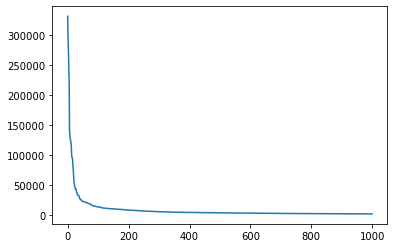

In [17]:
plt.plot(tag_sorted_count[0:1000])
plt.show()

In [18]:
i = 1000
print(f'{len(tag_data[tag_data.Counts >= i].Tags)} number of tags are used more than {i}')

1560 number of tags are used more than 1000


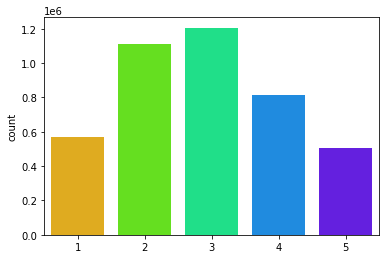

In [19]:
sns.countplot(tag_dtm.sum(axis = 1).A1, palette = 'gist_rainbow')
plt.show()

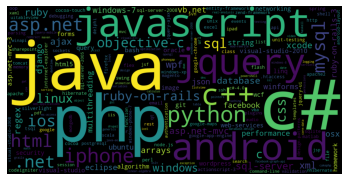

In [20]:
t = dict(zip(vectorizer.get_feature_names(),freq_tag))
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(t)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

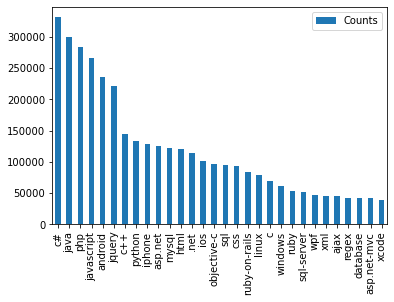

In [24]:
tag_data.sort_values(['Counts'], ascending = False).head(30).plot(kind = 'bar')
plt.xticks(np.arange(30), tag_data.sort_values(['Counts'], ascending = False).head(30).Tags)
plt.show()

### Data Preprocessing

In [25]:
def clean_html(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [26]:
sql_create_table = """CREATE TABLE IF NOT EXISTS Processedd (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
database = "Processed.db"
conn = sqlite3.connect(database)
cur = conn.cursor()
cur.execute(sql_create_table)
conn.close()

In [27]:
start = datetime.now()
read_db = 'Train_a.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = sqlite3.connect(read_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From train_a ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = sqlite3.connect(write_db)
    if conn_w is not None:
        checker = conn_w.cursor()
        tables_names = checker.execute("select name from sqlite_master where type='table'")
        tables = len(tables_names.fetchall())
        if tables != 0:
            checker.execute('DELETE FROM Processedd WHERE 1')

print('Time :', datetime.now() - start)

Time : 0:19:45.011715


In [33]:
nltk.download('punkt')
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=clean_html(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    checker.execute("insert into Processedd(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amars\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
number of questions completed= 600000
number of questions completed= 700000
number of questions completed= 800000
number of questions completed= 900000
Avg. length of questions(Title+Body) before processing: 1168
Avg. length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:43:57.056079


In [38]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [39]:
conn = sqlite3.connect(write_db)
reader = conn.cursor()
reader.execute("SELECT question FROM Processedd LIMIT 5")
print("Questions")
reader.fetchone()
for row in reader:
    print(row)
conn.close()

Questions
('instal font gimp tri download googl web font gimp copi past ttf file font nlibrari restart gimp font still show work window vista miss someth thank help',)
('googl mail moz box shadow insid html messag anyon know read css param gmail disallow filter insid messag exampl notic moz box shadow allow btw html tag guess ifram allow well list tag would nice',)
('dns registr valid wonder dns config good beginn als check syntax effect send modif gandi',)
('best way copi fill larg array smaller array c larg int array much smaller int array want fill larg array valu small array repeat copi small array larg array full larg larg larg small etc alreadi simpl method need someth eleg hope faster',)


In [3]:
write_db = 'Processed.db'
conn_r = sqlite3.connect(write_db)
preprocessed_data = pd.read_sql_query("SELECT question, Tags FROM Processedd", conn_r)
conn_r.commit()
conn_r.close()

In [20]:
preprocessed_data.shape

(999989, 2)

In [6]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [16]:
multilabel_y.shape

(999989, 35372)

In [17]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [21]:
questions_explained = []
for i in range(500, multilabel_y.shape[1], 100):
    questions_explained.append(np.round(((multilabel_y.shape[0]-questions_explained_fn(i))/multilabel_y.shape[0])*100,3))

In [38]:
xlabel

[-2000, 500, 3000, 5500, 8000, 10500, 13000, 15500, 18000, 20500]

<ipython-input-27-3f6dad988fd6>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabel)


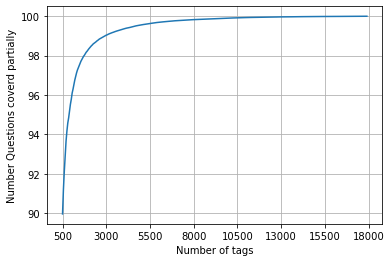

with  5500 tags we are covering  99.039 % of questions


In [27]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()

In [41]:
multilabel_yx = tags_to_choose(5500)

In [42]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [44]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print(datetime.now() - start)

0:03:03.824953


In [ ]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print(metrics.classification_report(y_test, predictions))